# LASSO regression, as predicted by one-hot encoded values of year, country, language, and occupation.


#### Metric of evaluation type and justification: 
We use R-squared as a metric of evaluation. A linear relationship is assumed to exist between the group of independent variables year, country, language, and occupation and the dependent (target) variable Religion_over_science; hence the Lasso regression algorithm will evaluate the data. Lasso regression also lowers complexity and reduces noise in the model. R-squared will show a good measurement of how well the model fits the dependent variables based on the penalties enforced by Lasso regression.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished


The model assigned an alpha weight of: 0.0001
R squared training set: 39.02
R squared test set: 39.24


,Alpha range,R2 (train),R2 (test)
0,0.000,0.390,0.392
1,0.033,0.058,0.056
2,0.067,0.002,0.002
3,0.100,0.001,0.001
4,0.133,0.000,0.000
5,0.167,0.000,-0.000
6,0.200,0.000,-0.000
7,0.233,0.000,-0.000
8,0.267,0.000,-0.000
9,0.300,0.000,-0.000


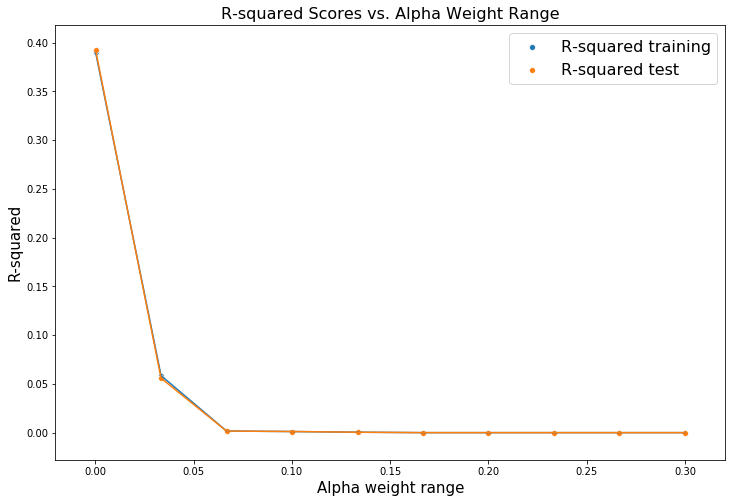

In [5]:
# load basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv

# load visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette()

# load sklearn packages
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


# Import the cleaned dataset - data.csv.
df = pd.read_csv('/Users/frankstaszak/Desktop/207_team_project/data/data.csv')

# *** One-hot encode dependent variables. ************************************************

# One-hot encode country.
df_country0 = df[['country']]
df_country1 = pd.get_dummies(df_country0[['country']], prefix='country')

# Add the encoded country column then drop the original country column.
df0 = pd.concat([df,df_country1],axis=1).drop(['country'], axis=1, inplace=False)

# One-hot encode language.
df_language0 = df[['language']]
df_language1 = pd.get_dummies(df_language0[['language']], prefix='language')

# Add the encoded language column then drop the original language column.
df1 = pd.concat([df0,df_language1],axis=1).drop(['language'], axis=1, inplace=False)

# One-hot encode occupation.
df_occupation0 = df[['occupation']]
df_occupation1 = pd.get_dummies(df_occupation0[['occupation']], prefix='occupation')

# Add the encoded occupation column then drop the original occupation column.
df2 = pd.concat([df1,df_occupation1],axis=1).drop(['occupation'], axis=1, inplace=False)

# One-hot encode year.
df_year0 = df[['year']]
df_year1 = pd.get_dummies(df_year0[['year']], prefix='year')

# Add the encoded year (S020) column then drop the original year (S020) column.
df3 = pd.concat([df2,df_year1],axis=1).drop(['year'], axis=1, inplace=False)

# Extract only the one-hot encoded columns for X.
reg_ex_country = df2.columns.str.contains('country.*')
reg_ex_language = df2.columns.str.contains('language.*')
reg_ex_occupation = df2.columns.str.contains('occupation.*')
reg_ex_year = df2.columns.str.contains('year.*')

# Select encoded country.
df4 = df2.iloc[:,reg_ex_country]
# Select encoded language.
df5 = df2.iloc[:,reg_ex_language]
# Select encoded occupation.
df6 = df2.iloc[:,reg_ex_occupation]
# Select encoded year.
df7 = df2.iloc[:,reg_ex_year]
# ****************************************************************************************


# *** Define data, train, and evaluate model. ********************************************

# Join all dependent variables.
df8 = pd.concat([df4,df5,df6,df7],axis=1)

# Define features (using independent variables).
X = df8
# Define target (using dependent variable)
y = df['Religion_over_science']

# Define train/test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Tuning

# Use 5-fold cross validation for model evaluation.
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

alpha = np.linspace(0.0001, 0.3, 10)
lasso_cv_model = LassoCV(alphas=alpha, cv=cv, n_jobs=1, verbose=True, random_state=1)
lasso_cv_model.fit(X_train, y_train)

# Sanity Check: Best alpha weight.
print(f'The model assigned an alpha weight of: {lasso_cv_model.alpha_}')

# Use the best alpha value from LassoCV.
lasso_best = Lasso(alpha = lasso_cv_model.alpha_)
lasso_pred = lasso_best.fit(X_train, y_train)

# Sanity Check: R-squared scores on training/testing sets.
print('R squared training set:', round(lasso_best.score(X_train, y_train) * 100, 2))
print('R squared test set:', round(lasso_best.score(X_test, y_test) * 100, 2))

r2_train_scores = []
r2_test_scores = []
for i in range(10):
    lasso = Lasso(alpha = alpha[i])
    lasso.fit(X_train, y_train)
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    r2_train_scores.append(r2_score(y_train, y_train_pred))    
    r2_test_scores.append(r2_score(y_test, y_test_pred))   
# ****************************************************************************************


report = pd.DataFrame({
    'Alpha range': alpha,
    'R2 (train)': r2_train_scores,
    'R2 (test)': r2_test_scores
})

display(report)

# *** Visualize results, R-squared vs Alpha weights. *************************************

# Plot the R-squared scores with the given range of alpha weights.
fontsize = 16
alpha = np.linspace(0.0001, 0.3, 10)
plt.figure(figsize=(12,8))
plt.title('R-squared Scores vs. Alpha Weight Range', fontdict={'fontsize': fontsize})
sns.scatterplot(alpha, r2_train_scores, label='R-squared training')
plt.plot(alpha, r2_train_scores)
sns.scatterplot(alpha, r2_test_scores, label='R-squared test')
plt.plot(alpha, r2_test_scores)
plt.xlabel('Alpha weight range', size=15)
plt.ylabel('R-squared', size=15)
plt.legend(prop={'size': fontsize})
# sns.set_style("whitegrid")
plt.show()
# ****************************************************************************************


#### Evaluation: 
We observe that as the alpha weight increases, the R-squared score decreases. The coefficients in the regression model display a value closer to zero as the alpha weight increases. This relationship indicates that the observed outcomes of the model decline based on the degree to which the alpha weighting increased.

Furthermore, the regression modeled nearly forty percent of the outcomes at its peak.



<font size="2">Sources:</font><font size="1"> 
*  sklearn.linear_model.Lasso. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
*  sklearn.model_selection.RepeatedKFold. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
*  Lasso and Elastic Net for Sparse Signals. https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py
*  sklearn.metrics.r2_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
*  What is the Difference Between Test and Validation Datasets? Brownlee, Jason. 2017  https://machinelearningmastery.com/difference-test-validation-datasets/
*  Repeated k-Fold Cross-Validation for Model Evaluation in Python. Brownlee, Jason. 2020 https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/</font>

In [2]:
import time
from sklearn.inspection import permutation_importance


# Define train/test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print('-'*100)
print('Feature importance based on feature permutation')
print('-'*100)

start_time = time.time()
result = permutation_importance(
    lasso_pred, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

lasso_importances = pd.Series(result.importances_mean, index=X.columns)


----------------------------------------------------------------------------------------------------
Feature importance based on feature permutation
----------------------------------------------------------------------------------------------------
Elapsed time to compute the importances: 5.222 seconds


In [3]:
print("-" * 100)
print("Top 10 most important features")
print("-" * 100)
lasso_importances.sort_values(ascending=False).head(10)

----------------------------------------------------------------------------------------------------
Top 10 most important features
----------------------------------------------------------------------------------------------------


language_Arabic        0.109
country_Nigeria        0.073
country_South Africa   0.071
country_Myanmar        0.046
country_Indonesia      0.041
country_Bangladesh     0.040
country_Ghana          0.036
country_Canada         0.035
country_Ethiopia       0.031
country_Zimbabwe       0.031
dtype: float64

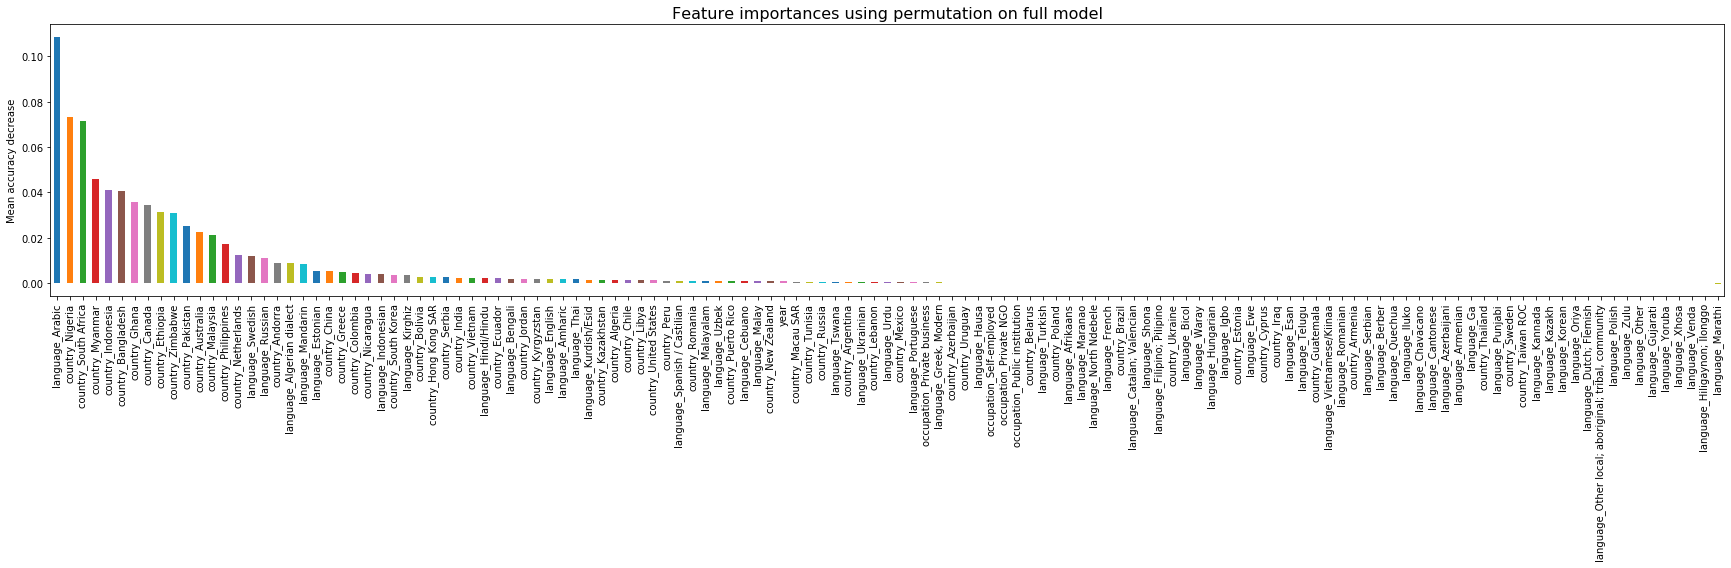

In [7]:
lasso_importances.sort_values(ascending=False).plot(kind='bar', figsize=(30,5), color=colors)
plt.title("Feature importances using permutation on full model", fontdict={'fontsize': fontsize})
plt.ylabel("Mean accuracy decrease")
plt.show()
plt.close()